In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size':18});
import cvxpy
import time

In [2]:
figDir = '/Users/aqib/Desktop/UCSB/research/BCCL/structured-dmd/sdmd_figures/'

In [4]:
def concat_metadata2tpmdata(dftpm,dfmd):
    # add the metadata to the tpm data

    # find the rows of the metadata which correspond to the columns of the tpm data
    metalist = list(dfmd['sample_id'])
    dfmd_match_rowInd = []
    dftpm_match_colInd = []
    sid_count = 1
    for sid in dftpm.iloc[:,1:]:
        dfmd_match_rowInd.append(metalist.index(sid))
        dftpm_match_colInd.append(sid_count)
        sid_count = sid_count + 1
    # dfmd.iloc[dfmd_match_rowInd,:]

    # rename the row indices with the gene names
    dftpm_geneindex = dftpm.set_index('gene_id')
    dftpm_geneindex.index.names = [None]
    # dftpm_geneindex

    # create a dataframe, md2append, which contains just the metadata that correponds to the experiments in tpm data
    sids = list(dftpm_geneindex.columns)
    md2append = dfmd.T.iloc[:,dfmd_match_rowInd]
    md2append.columns = sids

    # concatenate the metadata to the top of the columns of tpm data
    dftpm_final = pd.concat([md2append,dftpm_geneindex[:]])
    # dftpm_final
    
    return(dftpm_final)

def unique(list1): 
    # function to get unique values 
    
    # intilize a null list 
    unique_list = [] 
      
    # check all elements in the list
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x)
            
    return unique_list

def getUnique_inducerConditions(df):
    inducer_list = []
    
    # get all ara,iptg conditions i.e. get the condition of each experiment
    for index,row in df.loc[['arabinose_concentration','IPTG_concentration']].T.iterrows():
        inducer_list.append([row.arabinose_concentration, row.IPTG_concentration])
    
    # find the unique ara,iptg conditions
    inducer_conditions = np.asarray(unique(inducer_list))
    
    # return a sorted unique condition list
    return(inducer_conditions[np.lexsort([inducer_conditions[:,0],inducer_conditions[:,1]])])

def getInducerCond_dfs(df,input_state):
    # create a dataframe with a single inducer condition 
    input_state_list = []
    for header in df:
        if (np.asarray(df[header].iloc[[5,7]]) == input_state).all(): # rows 5 and 7 correspond to [ara] and [iptg], respectively
            input_state_list.append(header)

    return(df[input_state_list].sort_values(by=['replicate','timepoint'],axis=1))

def list_InducerCond_dfs(df,input_conditions):
    # create a list that contains lists that contains dataframes corresponding to a single inducer condition
    
    df_final = [[] for i in range(0,input_conditions.shape[0])]

    for i in range(0,len(df_final)):
        df_final[i] = getInducerCond_dfs(df,input_conditions[i])
    
    return(df_final)

def mean_filter(df,numMetadata,repList,mean_cutoff=10):
    '''filter genes with low expression (TPM)
    in which_reps, specify in a list which replicates to use for filtering. 
    e.g. I have noticed that replicate 4 has many genes with erroneous zeros. Filling those zeros would be 
    cumbersome, so I may not use replicate 4 for filtering or model identification'''
    df = df.T[df.T['replicate'].isin(repList)].T
    mean = np.mean(df[numMetadata:],axis=1)
    keepers_mean = []
    for i in range(len(mean)):
        if (mean[i] >= mean_cutoff):
            keepers_mean.append(i)
    return keepers_mean

def cv_filter(df,numMetadata,repList,cv_cutoff=0.15):
    '''filter genes with high cv'''
    # std over all replicates at timepoint t / mean over all replicates at timepoint t 
    df = df.T[df.T['replicate'].isin(repList)].T
    cvList = []
    tList = [5, 6.5, 8, 18]
    for t in tList:
        cvList.append(np.std((df.T[df.T['timepoint']==t].T)[numMetadata:],axis=1)/np.mean((df.T[df.T['timepoint']==t].T)[numMetadata:],axis=1))
#     cvMeaned = np.zeros(df[numMetadata:].shape[0])   
#     for i in range(len(cvList)):
#         cvMeaned += cvList[i]
#     cvMeaned = cvMeaned/len(cvList)
#     keepers_cv = []
#     for i in range(len(cvMeaned)):
#         if cvMeaned[i] <= cv_cutoff: 
#             keepers_cv.append(i)
    return cvList

def get_snapshots(df,timeList):
    '''Ensure that 'timepoint' is a feature of each snapshot of data. Then this function returns the 
    subsetted dataframe according to the timepoints in timeList. The dataframe will be ordered as t1R1, t2R1, ..., tMRJ'''
    return df.T[df.T['timepoint'].isin(timeList)].T

def snapshots(df,repList,keepers,numMetadata,timeList_p,timeList_f,inducerList):
    '''Build snapshots using get_snapshots. filter out the metadata and the low mean and high cv genes
    then collect the designated timepoints. do this for all inducer conditions. '''    
    metadataInds = list(range(0,numMetadata))
    keepInds = metadataInds + keepers
    dfReps = [[] for i in range(len(df))]
    # subset to get the designated replicates
    for i in range(len(dfReps)): 
        dfReps[i] = df[i].T[df[i].T['replicate'].isin(repList)].T
    # filter to keep designated genes
    for i in range(len(dfReps)):
        dfReps[i] = dfReps[i].iloc[keepInds]
    # subset to get the designated timepoints and simultaneously remove the metadata
    Xp,Xf = {},{}
    dictkeys = ['-ara-iptg','+ara-iptg','-ara+iptg','+ara+iptg']
    for i in range(len(dictkeys)):
        Xp[dictkeys[i]] = np.array((get_snapshots(dfReps[inducerList[i]],timeList_p))[numMetadata:],dtype=np.float32)
        Xf[dictkeys[i]] = np.array((get_snapshots(dfReps[inducerList[i]],timeList_f))[numMetadata:],dtype=np.float32)    
    return Xp,Xf

def input_snapshots(df,repList,keepers,numMetadata,timeList_p,inducerList,appendInducerSteps=False):
    '''Build snapshots using get_snapshots. filter out the metadata and the low mean and high cv genes
    then collect the designated timepoints. do this for all inducer conditions. '''    
    metadataInds = list(range(0,numMetadata))
    keepInds = metadataInds + keepers
    dfReps = [[] for i in range(len(df))]
    # subset to get the designated replicates
    for i in range(len(dfReps)): 
        dfReps[i] = df[i].T[df[i].T['replicate'].isin(repList)].T
    # filter to keep designated genes
    for i in range(len(dfReps)):
        dfReps[i] = dfReps[i].iloc[keepInds,:]
    # subset to get the designated timepoints and simultaneously remove the metadata
    Up = {}
    dictkeys = ['-ara-iptg','+ara-iptg','-ara+iptg','+ara+iptg']
    for i in range(len(dictkeys)):
        Up[dictkeys[i]] = np.array((get_snapshots(dfReps[inducerList[i]],timeList_p))[numMetadata:],dtype=np.float32)
        if appendInducerSteps:
            if i==1 or i==2: 
                Up[dictkeys[i]] = np.vstack((Up[dictkeys[i]], 1.0*np.ones((1,Up[dictkeys[i]].shape[1]))))        
            elif i==3: 
                Up[dictkeys[i]] = np.vstack((Up[dictkeys[i]], 1.0*np.ones((2,Up[dictkeys[i]].shape[1]))))
    return Up

def sparsity(A,thresh):
    return (np.absolute(A) > thresh) * A

def model_fit_dmd(loss_rhs,loss_lhs,sparse_thresh=2e-3,makeSparse=False,rank_reduce=False,flag=1,lam_vals=[1e-1]):
    '''Function to compute the model x_t+1 = Ax_t + Bu_t from data. 
    From Xf=AXp or Xf - AXp=BUp (A known) or Xf - (AXp + B_1Up + ... )=B_JUp (B_1 to B_J-1 known), we see 
    that the optimization can always be written as ||loss_lhs - operator*loss_rhs||_2 + λ||operator||_p
    Note that for the case of structured DMD, loss_rhs will always be Xp or Up 
    flag==1:
    If makeSparse is True, all entries of model below sparse_thresh will be set to zero.
    If rank_reduce is True, the data will be projected onto the first r left singular vectors before regression.
    flag==2:
    Regularizes model during optimization. Helps learn better models when facing sparse data. 
    '''
    start_time = time.time()
    
    if flag == 1:
    # exact DMD    
        if rank_reduce == False: 
            optimal_operator = loss_lhs @ np.linalg.pinv(loss_rhs)
        else: # only for autonomous case for now so loss_lhs = Xf and loss_rhs = Xp, no Up
            U,s,Vh = np.linalg.svd(loss_rhs)
            r = np.minimum(U.shape[1],Vh.shape[0])
            U_r = U[:,0:r] # truncate to rank-r
            s_r = s[0:r]
            Vh_r = Vh[0:r,:]
            operator_tilde = U_r.T @ loss_lhs @ Vh_r.T @ np.diag(1/s_r) # low-rank dynamics
            optimal_operator = U_r@operator_tilde@U_r.T
        
        if makeSparse:
            optimal_operator = sparsity(optimal_operator,sparse_thresh)
            
        print(time.time() - start_time, 'seconds for DMD')
        
        return optimal_operator
        
    elif flag == 2: 
    # sparse DMD    
        import cvxpy
        SOLVER = cvxpy.SCS
        operator = cvxpy.Variable(shape=(loss_lhs.shape[0],loss_rhs.shape[0]))
        lam = cvxpy.Parameter(nonneg=True)
        regularizer = lam * cvxpy.norm(operator,p=2)  
        loss_fn = cvxpy.norm(cvxpy.norm(loss_lhs-operator@loss_rhs,p=2,axis=0),p=2)
        objective = cvxpy.Minimize(loss_fn + regularizer)
        constraints = []
        problem = cvxpy.Problem(objective,constraints)
        
        operator_values = []
        for v in lam_vals:
            lam.value = v
            problem.solve(verbose=True,solver=SOLVER,max_iters=np.int(1e3))
            if makeSparse:
                optimal_operator = sparsity(operator.value,sparse_thresh)
            else:
                optimal_operator = operator.value
            operator_values.append(optimal_operator)
            
        print(time.time() - start_time, 'seconds for sparse DMD')
        
        return operator_values
    
def plot_eigvals(matrix):
    L = np.linalg.eigvals(matrix)
    plt.figure();
    plt.plot(np.real(L),np.imag(L),'o',mfc='None',mec='tab:blue',linewidth=4,mew=2);
    import math
    theta = np.linspace(0,2*math.pi,50)
    x = np.cos(theta)
    y = np.sin(theta)
    plt.plot(x,y,c='grey')
    plt.axis('equal')
    plt.xlabel(r'$Re(\lambda)$');
    plt.ylabel(r'$Im(\lambda)$');

def nstep_error(dataList,modelList,nreps):
    '''Kind of a mess of a function but it was difficult to generalize for the structured learning.
    This is what I was able to come up with. So far it is untested (1/20/21). Will test soon.  '''
    # first let's get what is common among all the cases. 
    Xp,Xf = dataList[0],dataList[1]
    A = modelList[0] 
    ntimepts = int(Xp.shape[1]/nreps)
    Xf_pred = np.zeros((Xf.shape[0],Xf.shape[1]))
    init_inds = list(range(0,Xf_pred.shape[1],ntimepts))
    if len(modelList) == 1:
        count = 0
        for i in range(0,nreps):
            x0 = Xp[:,i*(ntimepts):i*(ntimepts)+1] 
            for j in range(1,ntimepts+1):
                Xf_pred[:,count:count+1] = np.dot(np.linalg.matrix_power(A,j),x0) 
                count += 1 
    elif len(modelList) == 2: 
        Up = dataList[2]
        B = modelList[1]
        Xf_pred[:,init_inds] = np.dot(A,Xp[:,init_inds]) + np.dot(B,Up[:,init_inds]) # predict first column (in Xf) of each trajectory
        count = 0
        for i in range(0,nreps):
            count += 1 # since we've already obtained the first column of Xf of each trajectory, we need this
            for j in range(1,ntimepts):
                Xf_pred[:,count] = np.dot(A,Xf_pred[:,count-1]) + np.dot(B,Up[:,count])
                count += 1
    elif len(modelList) == 3: 
        U1,U2 = dataList[2],dataList[3]
        B1,B2 = modelList[1],modelList[2]
        Xf_pred[:,init_inds] = np.dot(A,Xp[:,init_inds])+np.dot(B1,U1[:,init_inds])+np.dot(B2,U2[:,init_inds])
        count = 0
        for i in range(0,nreps):
            count += 1 
            for j in range(1,ntimepts):
                Xf_pred[:,count] = np.dot(A,Xf_pred[:,count-1])+np.dot(B1,U1[:,count])+np.dot(B2,U2[:,count])
                count += 1
    elif len(modelList) == 4: 
        U1,U2,U3 = dataList[2],dataList[3],dataList[4]
        B1,B2,B3 = modelList[1],modelList[2],modelList[3]
        Xf_pred[:,init_inds] = np.dot(A,Xp[:,init_inds])+np.dot(B1,U1[:,init_inds])+np.dot(B2,U2[:,init_inds])+\
                                np.dot(B3,U3[:,init_inds])
        count = 0
        for i in range(0,nreps):
            count += 1 
            for j in range(1,ntimepts):
                Xf_pred[:,count] = np.dot(A,Xf_pred[:,count-1])+np.dot(B1,U1[:,count])+np.dot(B2,U2[:,count])+\
                                    np.dot(B3,U3[:,count])
                count += 1
    elif len(modelList) == 5: 
        U1,U2,U3,U4 = dataList[2],dataList[3],dataList[4],dataList[5]
        B1,B2,B3,B4 = modelList[1],modelList[2],modelList[3],modelList[4]
        Xf_pred[:,init_inds] = np.dot(A,Xp[:,init_inds])+np.dot(B1,U1[:,init_inds])+np.dot(B2,U2[:,init_inds])+\
                                np.dot(B3,U3[:,init_inds])+np.dot(B4,U4[:,init_inds])
        count = 0
        for i in range(0,nreps):
            count += 1 
            for j in range(1,ntimepts):
                Xf_pred[:,count] = np.dot(A,Xf_pred[:,count-1])+np.dot(B1,U1[:,count])+np.dot(B2,U2[:,count])+\
                                    np.dot(B3,U3[:,count])+np.dot(B4,U4[:,count])
                count += 1
    elif len(modelList) == 6: 
        U1,U2,U3,U4,U5 = dataList[2],dataList[3],dataList[4],dataList[5],dataList[6]
        B1,B2,B3,B4,B5 = modelList[1],modelList[2],modelList[3],modelList[4],modelList[5]
        Xf_pred[:,init_inds] = np.dot(A,Xp[:,init_inds])+np.dot(B1,U1[:,init_inds])+np.dot(B2,U2[:,init_inds])+\
                                np.dot(B3,U3[:,init_inds])+np.dot(B4,U4[:,init_inds])+np.dot(B5,U5[:,init_inds])
        count = 0
        for i in range(0,nreps):
            count += 1 
            for j in range(1,ntimepts):
                Xf_pred[:,count] = np.dot(A,Xf_pred[:,count-1])+np.dot(B1,U1[:,count])+np.dot(B2,U2[:,count])+\
                                    np.dot(B3,U3[:,count])+np.dot(B4,U4[:,count])+np.dot(B5,U5[:,count])
                count += 1            
    
    feature_means = np.mean(Xf,axis=1).reshape(len(Xf),1)
    cd = 1 - ((np.linalg.norm(Xf - Xf_pred,ord=2)**2)/(np.linalg.norm(Xf - feature_means,ord=2)**2))
    print(f'Coefficient of determination for n-step prediction is {cd:.3e}')
    return cd

def onestep_error(dataList,modelList):
    '''In an attempt to keep the function general for structured learning, I am going to use the length 
    of modelList to inform how to compute the error in the predictions
    - modelList = [A, B1, B2, B3, ..., BJ] is the structure
    There will always be an Xp which A acts on, and there will always be an Xf. For each Bi there will 
    be a corresponding Ui'''
    
    if len(modelList) == 1:
        Xp,Xf = dataList[0],dataList[1]
        A = modelList[0]
        Xf_pred = A@Xp
    elif len(modelList) == 2: 
        Xp,Xf,Up = dataList[0],dataList[1],dataList[2]
        A,B = modelList[0],modelList[1]
        Xf_pred = A@Xp + B@Up
    elif len(modelList) == 3: 
        Xp,Xf,U1,U2 = dataList[0],dataList[1],dataList[2],dataList[3]
        A,B1,B2 = modelList[0],modelList[1],modelList[2]
        Xf_pred = A@Xp + B1@U1 + B2@U2
    elif len(modelList) == 4: 
        Xp,Xf,U1,U2,U3 = dataList[0],dataList[1],dataList[2],dataList[3],dataList[4]
        A,B1,B2,B3 = modelList[0],modelList[1],modelList[2],modelList[3]
        Xf_pred = A@Xp + B1@U1 + B2@U2 + B3@U3
    elif len(modelList) == 5:
        Xp,Xf,U1,U2,U3,U4 = dataList[0],dataList[1],dataList[2],dataList[3],dataList[4],dataList[5]
        A,B1,B2,B3,B4 = modelList[0],modelList[1],modelList[2],modelList[3],modelList[4]
        Xf_pred = A@Xp + B1@U1 + B2@U2 + B3@U3 + B4@U4
    elif len(modelList) == 6: 
        Xp,Xf,U1,U2,U3,U4,U5 = dataList[0],dataList[1],dataList[2],dataList[3],dataList[4],dataList[5],dataList[6]
        A,B1,B2,B3,B4,B5 = modelList[0],modelList[1],modelList[2],modelList[3],modelList[4],modelList[5]
        Xf_pred = A@Xp + B1@U1 + B2@U2 + B3@U3 + B4@U4 + B5@U5
        
    feature_means = np.mean(Xf,axis=1).reshape(len(Xf),1)
    cd = 1 - ((np.linalg.norm(Xf - Xf_pred,ord=2)**2)/(np.linalg.norm(Xf - feature_means,ord=2)**2))
    print(f'Coefficient of determination for 1-step prediction is {cd:.3e}')    
    return cd


#### importing expression data

In [9]:
df_tpm1 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_1.tsv', sep='\t') # replicates 1,2,3,4 if they exist
df_tpm2 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_2.tsv', sep='\t') # replicates 5,6,7,8 if they exist
df_metadata = pd.read_csv('NANDiterate_metadata.csv', sep=',')

In [12]:
df_tpm1

,gene_id,sample.ginkgo.11588608,sample.ginkgo.11588609,sample.ginkgo.11588610,sample.ginkgo.11588611,sample.ginkgo.11588612,sample.ginkgo.11588613,sample.ginkgo.11588614,sample.ginkgo.11588749,sample.ginkgo.11588790,sample.ginkgo.11588792,sample.ginkgo.11588619,sample.ginkgo.11588620,sample.ginkgo.11588621,sample.ginkgo.11588622,sample.ginkgo.11588623,sample.ginkgo.11588759,sample.ginkgo.11588624,sample.ginkgo.11588625,sample.ginkgo.11588626,sample.ginkgo.11588627,sample.ginkgo.11588628,sample.ginkgo.11588760,sample.ginkgo.11588629,sample.ginkgo.11588630,...,sample.ginkgo.11588586,sample.ginkgo.11588587,sample.ginkgo.11588588,sample.ginkgo.11588752,sample.ginkgo.11588589,sample.ginkgo.11588748,sample.ginkgo.11588579,sample.ginkgo.11588590,sample.ginkgo.11588591,sample.ginkgo.11588592,sample.ginkgo.11588593,sample.ginkgo.11588753,sample.ginkgo.11588594,sample.ginkgo.11588793,sample.ginkgo.11588754,sample.ginkgo.11588599,sample.ginkgo.11588787,sample.ginkgo.11588600,sample.ginkgo.11588601,sample.ginkgo.11588602,sample.ginkgo.11588603,sample.ginkgo.11588604,sample.ginkgo.11588605,sample.ginkgo.11588606,sample.ginkgo.11588607
0,thrL,588.843631,682.754914,500.461538,504.914986,369.158993,342.519025,367.606025,814.194502,753.619853,1221.743730,328.501565,851.385218,404.410673,366.685997,358.405739,212.254680,148.949698,127.071950,500.579086,253.613752,202.389644,44.799234,234.001643,230.594507,...,941.352733,437.353031,422.975738,1305.656459,262.268084,826.730739,648.991859,342.414268,755.922276,617.314443,426.326586,1252.004190,530.590564,1341.951941,1149.315079,1399.133335,770.455298,635.890085,675.600984,431.843401,328.148766,314.314947,543.371500,637.636442,409.239165
1,thrA,1130.489078,663.211990,832.613547,730.069980,997.197782,840.599402,1129.932779,1534.507056,1251.268599,2297.217302,548.430027,944.370449,771.311148,812.043271,755.006500,10.983148,327.511942,302.716306,798.121831,525.296109,483.154080,28.811201,903.366947,809.468172,...,844.149253,276.321409,555.915692,3012.133605,597.487797,2388.289861,327.698480,459.684200,825.390917,1093.270646,967.440764,2299.163825,940.537205,2871.731845,2338.640106,1475.437118,1265.160797,194.372293,512.078978,900.889125,1033.208964,528.761023,1231.482547,802.029109,777.430040
2,thrB,702.752290,393.876684,460.784673,496.269407,729.230367,612.185094,757.653411,678.349974,754.658374,1258.997667,279.937474,327.900416,594.327646,619.144056,551.691304,24.334332,216.976623,211.019294,540.574069,456.159846,449.853712,31.690777,651.711357,575.317040,...,591.857429,195.254144,363.005205,1231.487335,401.357309,1038.363826,123.831279,323.140535,520.915146,673.223414,607.924828,1169.435503,612.961040,1398.954807,1107.193792,352.362545,687.447617,164.333339,286.750257,590.518396,729.278098,347.478664,854.207416,554.941898,553.973362
3,thrC,650.699001,381.219919,429.482618,490.705371,614.348961,557.597801,695.893018,505.682055,426.122714,820.479584,259.549537,280.928456,631.502820,547.118789,511.938180,27.399808,257.868280,230.207015,546.721397,389.961792,355.069551,41.353139,585.846810,490.600805,...,507.783632,164.973052,335.392954,841.919027,398.109501,688.509666,98.585596,331.125886,529.950718,607.481540,590.298349,729.844410,546.740249,929.647318,728.184740,281.067464,443.044722,187.792820,311.815839,554.377480,641.339183,399.406769,784.941394,525.418373,495.936335
4,yaaX,59.095418,37.930829,38.229701,65.679998,66.157526,77.734814,55.432655,0.000000,23.924440,39.657100,39.046698,42.999253,69.648505,68.874883,40.353831,14.638254,31.874009,37.464557,78.853527,42.499937,34.717912,0.000000,45.573354,47.958402,...,65.968472,51.834433,36.356405,32.238431,42.739984,17.809392,34.301071,29.266177,69.777441,71.708243,49.862759,19.873082,46.654646,52.317814,21.970181,43.248065,38.808119,36.214846,42.895301,58.689461,81.024387,52.791916,52.015050,80.509652,34.434363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

#### concatenating metadata to expression data

In [5]:
df_tpm1_final = concat_metadata2tpmdata(df_tpm1,df_metadata)
df_tpm2_final = concat_metadata2tpmdata(df_tpm2,df_metadata)
df_tpm_final = pd.concat([df_tpm1_final,df_tpm2_final],axis=1)

#### preprocessing

In [6]:
# get all unique strain names from the data
strainNames = unique(list(df_tpm_final.loc['strain']))
numStrains = len(strainNames)
strainNames

['MG1655_pBADmin',
 'MG1655_pJS007_LALT__I1__IcaRA',
 'MG1655_empty_landing_pads',
 'MG1655_PhlF_Gate',
 'MG1655_pTACmin',
 'MG1655_pJS007_LALT__backbone',
 'MG1655_WT',
 'MG1655_NAND_Circuit',
 'MG1655_pJS007_LALT__P3__PhlF',
 'MG1655_IcaR_Gate']

In [7]:
# create a new dataframe for each strain (or at least the ones we'll analyze, since we won't look at strain 7: MG1655_pJS007_LALT_backbone)

# each strain has many inducer conditions, 10 to be exact
df_wt = pd.DataFrame() # wild type e. coli
df_phlf = pd.DataFrame() # added phlf, sensors, actuator genes on genome
df_icar = pd.DataFrame() # added icar, sensors, actuator genes on genome
df_nand = pd.DataFrame() # added phlf, icar, sensors, actuator genes on genome
df_phlf_plasmid = pd.DataFrame()
df_icar_plasmid = pd.DataFrame()
df_empty_landpads = pd.DataFrame()

for header in df_tpm_final:
    if df_tpm_final[header].loc['strain'] == 'MG1655_WT':
        df_wt[header] = df_tpm_final[header]
    elif df_tpm_final[header].loc['strain'] == 'MG1655_PhlF_Gate':
        df_phlf[header] = df_tpm_final[header]
    elif df_tpm_final[header].loc['strain'] == 'MG1655_IcaR_Gate':
        df_icar[header] = df_tpm_final[header]
    elif df_tpm_final[header].loc['strain'] == 'MG1655_NAND_Circuit':
        df_nand[header] = df_tpm_final[header]
    elif df_tpm_final[header].loc['strain'] == 'MG1655_pJS007_LALT__P3__PhlF':
        df_phlf_plasmid[header] = df_tpm_final[header]
    elif df_tpm_final[header].loc['strain'] == 'MG1655_pJS007_LALT__I1__IcaRA':
        df_icar_plasmid[header] = df_tpm_final[header]
    elif df_tpm_final[header].loc['strain'] == 'MG1655_empty_landing_pads':
        df_empty_landpads[header] = df_tpm_final[header]

<ipython-input-7-b31011641ac8>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_phlf[header] = df_tpm_final[header]
<ipython-input-7-b31011641ac8>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_wt[header] = df_tpm_final[header]
<ipython-input-7-b31011641ac8>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newfra

In [8]:
# get all unique inducer combinations that exist in the data

inducer_conditions = getUnique_inducerConditions(df_wt) # all strains have same unique inducer conditions, I checked
inducer_conditions # there are 10 unique inducer conditions
# labeled as follows:
# [ara_conc, iptg_conc]
# [0, 0]
# [1, 0]
# [2, 0]
# [3, 0]
# [0, 1]
# [1, 1]
# [0, 2]
# [2, 2]
# [0, 3]
# [3, 3]


array([[0.0000000e+00, 0.0000000e+00],
       [6.2447240e-03, 0.0000000e+00],
       [7.4930000e-03, 0.0000000e+00],
       [3.7313000e-02, 0.0000000e+00],
       [0.0000000e+00, 6.2447905e-05],
       [6.2447240e-03, 6.2447905e-05],
       [0.0000000e+00, 7.4925000e-05],
       [7.4930000e-03, 7.4925000e-05],
       [0.0000000e+00, 3.7313400e-04],
       [3.7313000e-02, 3.7313400e-04]])

In [9]:
# these dfs are s.t. each element of the list corresponds to the inducer condition in the same element of inducer_conditions
df_wt_final = list_InducerCond_dfs(df_wt,inducer_conditions)  # control for the genome circuits
df_phlf_final = list_InducerCond_dfs(df_phlf,inducer_conditions)
df_icar_final = list_InducerCond_dfs(df_icar,inducer_conditions)
df_nand_final = list_InducerCond_dfs(df_nand,inducer_conditions)
df_phlf_plasmid_final = list_InducerCond_dfs(df_phlf_plasmid,inducer_conditions)
df_icar_plasmid_final = list_InducerCond_dfs(df_icar_plasmid,inducer_conditions)
df_empty_landpads_final = list_InducerCond_dfs(df_empty_landpads,inducer_conditions) # control for the 

numMetadata = 10 # first 10 rows of the dfs are metadata
all_gene_names = list(df_tpm_final.index[numMetadata:df_tpm_final.shape[0]])
numGenes = df_wt_final[0].iloc[numMetadata:].shape[0]
circuit_gene_names = list(df_tpm_final.index[-13:])
circuit_gene_names

['Sensor_TetR',
 'Sensor_LacI',
 'Sensor_AraC',
 'Sensor_LuxR',
 'Circuit_PhlF',
 'KanR',
 'CamR',
 'Actuator_YFP',
 'rsd_1',
 'rsd_2',
 'fecA_1',
 'fecA_2',
 'Circuit_IcaR']

In [319]:
df_wt_cond = df_wt.iloc[:10,:].T.sort_values(['arabinose_concentration','IPTG_concentration','timepoint','replicate'])  
df_phlf_cond = df_phlf.iloc[:10,:].T.sort_values(['arabinose_concentration','IPTG_concentration','timepoint','replicate'])  
df_icar_cond = df_icar.iloc[:10,:].T.sort_values(['arabinose_concentration','IPTG_concentration','timepoint','replicate'])  
df_nand_cond = df_nand.iloc[:10,:].T.sort_values(['arabinose_concentration','IPTG_concentration','timepoint','replicate'])  
df_phlf_plasmid_cond = df_phlf_plasmid.iloc[:10,:].T.sort_values(['arabinose_concentration','IPTG_concentration','timepoint','replicate'])  
df_icar_plasmid_cond = df_icar_plasmid.iloc[:10,:].T.sort_values(['arabinose_concentration','IPTG_concentration','timepoint','replicate'])  
df_empty_landpads_cond = df_empty_landpads.iloc[:10,:].T.sort_values(['arabinose_concentration','IPTG_concentration','timepoint','replicate'])  

In [325]:
def cmap_bounds(bounds):
    '''bounds is where the colors change (should be one more than # of colors)'''
    my_bounds = (len(bounds)+1)*[0]
    my_bounds[0] = bounds[0]
    for ii in range(1,len(bounds)):
        my_bounds[ii] = (bounds[ii] - bounds[ii-1])/2 + bounds[ii-1]
    my_bounds[-1] = bounds[-1]
    return my_bounds

def plotCondHeatmap(df_by_strain,strain_name='WT'):
    
    plt.rcParams.update({'font.size':18});    
    fig, ax = plt.subplots(figsize=(9,12))
    N = len(df_wt_cond) # 7 strains of interest
    ax.set_xlim(0,10)

    # make a color map of fixed colors
    cmap = matplotlib.colors.ListedColormap(['snow','lightgray','darkgray','k'])
    bounds = list(np.sort(df_by_strain['arabinose_concentration'].unique()))
    my_bounds = cmap_bounds(bounds)
    norm = matplotlib.colors.BoundaryNorm(my_bounds, cmap.N)
    im1 = ax.imshow(np.array(df_by_strain['arabinose_concentration'],dtype='float')[:,np.newaxis],norm=norm,aspect='auto',extent=[0,2.5,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')
    cmap = matplotlib.colors.ListedColormap(['snow','lightgray','darkgray','k'])
    bounds = list(np.sort(df_by_strain['IPTG_concentration'].unique()))
    my_bounds = cmap_bounds(bounds)
    norm = matplotlib.colors.BoundaryNorm(my_bounds, cmap.N)
    im2 = ax.imshow(np.array(df_by_strain['IPTG_concentration'],dtype='float')[:,np.newaxis],norm=norm,aspect='auto',extent=[2.5,5,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')
    cmap = matplotlib.colors.ListedColormap(['navajowhite','orange','goldenrod','saddlebrown'])
    bounds = list(np.sort(df_by_strain['timepoint'].unique()))
    my_bounds = cmap_bounds(bounds)
    norm = matplotlib.colors.BoundaryNorm(my_bounds, cmap.N)
    im3 = ax.imshow(np.array(df_by_strain['timepoint'],dtype='float')[:,np.newaxis],norm=norm,aspect='auto',extent=[5,7.5,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')
    cmap = matplotlib.cm.get_cmap('Greens',8)
    im4 = ax.imshow(np.array(df_by_strain['replicate'],dtype='float')[:,np.newaxis],aspect='auto',extent=[7.5,10,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')

    plt.rcParams.update({'font.size':14});
    cbax = fig.add_axes([1.05, 0.83, 1.0, 0.05]) # left, bottom, width, height
    cbar1 = fig.colorbar(im1, cax=cbax, label='[ara]',fraction=0.027,orientation='horizontal',ticks=np.round(df_wt_cond['arabinose_concentration'].unique().astype('float'),3))
    cbax = fig.add_axes([1.05, 0.6, 1.0, 0.05]) # left, bottom, width, height
    cbar2 = fig.colorbar(im2, cax=cbax, label='[IPTG]',fraction=0.027,orientation='horizontal',ticks=np.round(df_wt_cond['IPTG_concentration'].unique().astype('float'),5))
    cbax = fig.add_axes([1.05, 0.37, 1.0, 0.05]) # left, bottom, width, height
    cbar3 = fig.colorbar(im3, cax=cbax, label='time (hrs)',fraction=0.041,orientation='horizontal',ticks=(df_wt_cond['timepoint'].unique().astype('float')))
    cbax = fig.add_axes([1.05, 0.13, 1.0, 0.05]) # left, bottom, width, height
    cbar4 = fig.colorbar(im4, cax=cbax, label='replicate',fraction=0.033,orientation='horizontal',ticks=[0,1,2,3,4,5,6,7,8])

    ax.set_xticks([1.25,3.75,6.25,8.75])
    ax.set_xticklabels(['[ara]','[IPTG]','time','rep'])
    ax.set_yticklabels([])
    ax.set_title(strain_name + ' (NAND iterate)')

    plt.savefig(figDir+strain_name+'Iterate_condition_heatmap.pdf',bbox_inches='tight',dpi=300,transparent=True)

    plt.show()

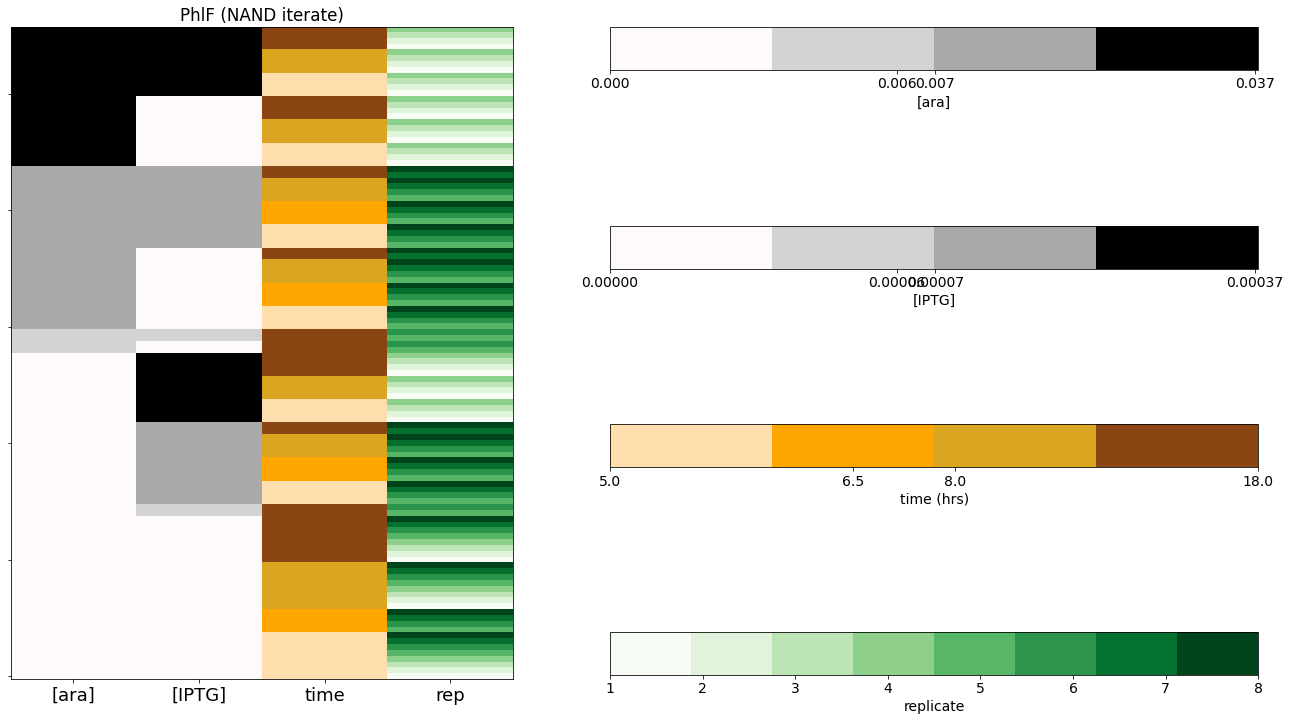

In [328]:
plotCondHeatmap(df_phlf_cond,strain_name='PhlF')

In [10]:
# filter genes with low mean expression
# going to filter based on the the un-induced wild type strain. df_wt_final[0]
keepers_mean = mean_filter(df_wt_final[0],numMetadata,mean_cutoff=10)

#  filter genes with high cv across replicates. 
keepers_cv = cv_filter(df_wt_final[0],numMetadata,cv_cutoff=0.25)

# get intersection of the two lists
keepers_wt = list(set(keepers_mean) & set(keepers_cv))
keepers_wt.sort()
gene_names = [all_gene_names[i] for i in keepers_wt]
keepers_wt = [x+numMetadata for x in keepers_wt] # shift the keepers indices by 10 to account for metadata
print(len(keepers_wt))

# create a keepers for each strain to include relevant circuit genes
# circuit genes start at row index 4107 and end at row index 4119
circuit_genes_phlf = list(range(4107,4119))
# keepers_phlf = keepers_wt + circuit_genes_phlf
circuit_genes_icar = list(range(4107,4111)) + list(range(4112,4120))
# keepers_icar = keepers_wt + circuit_genes_icar
circuit_genes_nand = list(range(4107,4120))
# keepers_nand = keepers_wt + circuit_genes_nand
circuit_genes_phlf_plasmid = list(range(4107,4112)) + [4114]
# keepers_phlf_plasmid = keepers_wt + circuit_genes_phlf_plasmid
circuit_genes_icar_plasmid = list(range(4107,4111)) + [4112,4114,4119]
# keepers_icar_plasmid = keepers_wt + circuit_genes_icar_plasmid
circuit_genes_empty_landpads = list(range(4107,4111)) + list(range(4115,4119))
# keepers_empty_landpads = keepers_wt + circuit_genes_empty_landpads

TypeError: mean_filter() missing 1 required positional argument: 'repList'

#### making sure the lac and ara operons remain in the dataset (should be 13 in total) 

In [ ]:
repList1_cvFilter = [1,2,3] # I noticed that there were many erroneous zeros in replicate 4. could fill them in with averages, but for now not dealing with
repList2_cvFilter = [5,6,7,8] # Deciding to split up the filtering among the two datasets as well. there seems to be a lot of variation between the two datasets (reps 1:4 and reps 5:8)
df = df_wt_final[0].T[df_wt_final[0].T['replicate'].isin(repList2_cvFilter)].T
np.std((df.T[df.T['timepoint']==5].T).iloc[numMetadata:],axis=1)/np.mean((df.T[df.T['timepoint']==5].T).iloc[numMetadata:],axis=1)

In [ ]:
checkInds = df.index.get_loc('araC')
df.iloc[checkInds:checkInds+1]

In [ ]:
t1,t2,t3,t4 = [0,4,8,16,20,24],[],[],[]
m=np.mean(df.iloc[checkInds:checkInds+1,0:4],axis=1)
s=np.std(df.iloc[checkInds:checkInds+1],axis=1)

In [ ]:
# the CV filter is broken!
plt.figure();
plt.plot((df_wt_final[0].T[df_wt_final[0].T['replicate'].isin(repList)].T).loc['lacI'],'o');

In [ ]:
lacInds = [];
for ind in range(0,len(gene_names)):
    if 'lac' in str(gene_names[ind]):
        lacInds.append(ind)

araInds = [];
for ind in range(0,len(gene_names)):
    if 'ara' in str(gene_names[ind]):
        araInds.append(ind)  
        
for ind in araInds:
    print(gene_names[ind])
    
for ind in lacInds:
    print(gene_names[ind])

#### build state and input snapshot matrices
The inducer conditions valid for replicates 1:4 are [0,3,8,9] \
The inducer conditions valid for replicates 5:8 are [0,2,6,7]

In [ ]:
repList = [5,6,7,8]
inducerList = [0,2,6,7]
timeList_p = [5,6.5]
timeList_f = [6.5,8]

In [ ]:
# wild type 
Xp_wt,Xf_wt = snapshots(df_wt_final,repList,keepers_wt,numMetadata,timeList_p,timeList_f,inducerList)
# the snapshots function subsets for the replicates, timepoints, and genes that are designated in cell above. 
U_wt_single_inducer = 1.0*np.ones((1,Xp_wt['+ara-iptg'].shape[1])) # treating inducers as step inputs which are constant over time. might be more sophisticated to treat as a linear curve with negative slope
U_wt_double_inducer = 1.0*np.ones((2,Xp_wt['+ara+iptg'].shape[1]))

# phlf 
Xp_phlf,Xf_phlf = snapshots(df_phlf_final,repList,keepers_wt,numMetadata,timeList_p,timeList_f,inducerList)
U_phlf = input_snapshots(df_phlf_final,repList,circuit_genes_phlf,numMetadata,timeList_p,inducerList) 

# icar 
Xp_icar,Xf_icar = snapshots(df_icar_final,repList,keepers_wt,numMetadata,timeList_p,timeList_f,inducerList)
U_icar = input_snapshots(df_icar_final,repList,circuit_genes_icar,numMetadata,timeList_p,inducerList) 

# nand 
Xp_nand,Xf_nand = snapshots(df_nand_final,repList,keepers_wt,numMetadata,timeList_p,timeList_f,inducerList)
U_nand = input_snapshots(df_nand_final,repList,circuit_genes_nand,numMetadata,timeList_p,inducerList) 

# phlf_plasmid 
Xp_phlf_plasmid,Xf_phlf_plasmid = snapshots(df_phlf_plasmid_final,repList,keepers_wt,numMetadata,timeList_p,\
                                            timeList_f,inducerList)
U_phlf_plasmid = input_snapshots(df_phlf_plasmid_final,repList,circuit_genes_phlf_plasmid,numMetadata,timeList_p,\
                                 inducerList) 

# icar_plasmid 
Xp_icar_plasmid,Xf_icar_plasmid = snapshots(df_icar_plasmid_final,repList,keepers_wt,numMetadata,timeList_p,\
                                            timeList_f,inducerList)
U_icar_plasmid = input_snapshots(df_icar_plasmid_final,repList,circuit_genes_icar_plasmid,numMetadata,timeList_p,\
                                 inducerList)

# empty_landpads 
Xp_empty_landpads,Xf_empty_landpads = snapshots(df_empty_landpads_final,repList,keepers_wt,numMetadata,timeList_p,\
                                            timeList_f,inducerList)
U_empty_landpads = input_snapshots(df_empty_landpads_final,repList,circuit_genes_empty_landpads,numMetadata,\
                                           timeList_p,inducerList)

#### Model for autonomous (host) dynamics of wild type strain

In [ ]:
# Kwt = model_fit_dmd(Xp_wt['-ara-iptg'],Xf_wt['-ara-iptg'],makeSparse=False,rank_reduce=False,flag=1)
LAM_VALS = np.logspace(-1,3,3)
Kwt = model_fit_dmd(Xp_wt['-ara-iptg'],Xf_wt['-ara-iptg'],makeSparse=False,\
                                         rank_reduce=False,flag=2,lam_vals=LAM_VALS)
onestep_error([Xp_wt['-ara-iptg'],Xf_wt['-ara-iptg']],[Kwt])
nstep_error([Xp_wt['-ara-iptg'],Xf_wt['-ara-iptg']],[Kwt],4)

In [ ]:
for i in range(len(Kwt_sparse_vals)):
    print('lambda =',LAM_VALS[i])
    onestep_error([Xp_wt['-ara-iptg'],Xf_wt['-ara-iptg']],[Kwt_sparse_vals[i]])
    nstep_error([Xp_wt['-ara-iptg'],Xf_wt['-ara-iptg']],[Kwt_sparse_vals[i]],4)

#### Model for impact of inducers on autonomous dynamics of wild type strain

In [ ]:
Ku_ara = (X2f_wt_ara - Kx_wt @ X2p_wt_ara) @ np.linalg.pinv(U2_wt_single_inducer)
Ku_ara_iptg = (X2f_wt_ara_iptg - Kx_wt @ X2p_wt_ara_iptg) @ np.linalg.pinv(U2_wt_double_inducer)